In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import random
import gym
import pylab
import numpy as np
import pandas as pd
from collections import deque
from keras.models import Model, load_model, clone_model
from keras.layers import Input, Dense
from keras.optimizers import Adam, RMSprop

In [3]:
def OurModel(input_shape, action_space):
    X_input = Input(input_shape)
    X = X_input

    # 'Dense' is the basic form of a neural network layer
    # Input Layer of state size(4) and Hidden Layer with 512 nodes
    X = Dense(512, input_shape=input_shape, activation="relu", kernel_initializer='he_uniform')(X)

    # Hidden layer with 256 nodes
    X = Dense(256, activation="relu", kernel_initializer='he_uniform')(X)

    # Hidden layer with 64 nodes
    X = Dense(64, activation="relu", kernel_initializer='he_uniform')(X)

    # Output Layer with # of actions: 2 nodes (left, right)
    X = Dense(action_space, activation="linear", kernel_initializer='he_uniform')(X)

    model = Model(inputs = X_input, outputs = X, name='DDQN')
    model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.00025), metrics=["accuracy"])

    model.summary()
    return model

In [4]:
class DQNAgent:
    def __init__(self, env_name):
        self.env_name = env_name
        self.env = gym.make(env_name)
        self.env.seed(0)
        # by default, CartPole-v1 has max episode steps = 500
        self.env._max_episode_steps = 4000
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n

        self.EPISODES = 150
        self.memory = deque(maxlen=2000)

        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        self.batch_size = 32
        self.train_start = 1000

        # defining model parameters
        self.ddqn = True
        self.Soft_Update = False

        self.TAU = 0.1 # target network soft update hyperparameter

        self.Save_Path = 'Models'
        self.scores, self.episodes, self.average = [], [], []

        if self.ddqn:
            print("----------Double DQN--------")
            self.Model_name = os.path.join(self.Save_Path,"DDQN_"+self.env_name+".h5")
        else:
            print("-------------DQN------------")
            self.Model_name = os.path.join(self.Save_Path,"DQN_"+self.env_name+".h5")

        # create main model
        self.model = OurModel(input_shape=(self.state_size,), action_space = self.action_size)
        self.target_model = OurModel(input_shape=(self.state_size,), action_space = self.action_size)

    # after some time interval update the target model to be same with model
    def update_target_model(self):
        if not self.Soft_Update and self.ddqn:
            self.target_model.set_weights(self.model.get_weights())
            return
        if self.Soft_Update and self.ddqn:
            q_model_theta = self.model.get_weights()
            target_model_theta = self.target_model.get_weights()
            counter = 0
            for q_weight, target_weight in zip(q_model_theta, target_model_theta):
                target_weight = target_weight * (1-self.TAU) + q_weight * self.TAU
                target_model_theta[counter] = target_weight
                counter += 1
            self.target_model.set_weights(target_model_theta)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) > self.train_start:
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

    def act(self, state):
        if np.random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            return np.argmax(self.model.predict(state))

    def replay(self):
        if len(self.memory) < self.train_start:
            return
        # Randomly sample minibatch from the memory
        minibatch = random.sample(self.memory, min(self.batch_size, self.batch_size))

        state = np.zeros((self.batch_size, self.state_size))
        next_state = np.zeros((self.batch_size, self.state_size))
        action, reward, done = [], [], []

        # do this before prediction
        # for speedup, this could be done on the tensor level
        # but easier to understand using a loop
        for i in range(self.batch_size):
            state[i] = minibatch[i][0]
            action.append(minibatch[i][1])
            reward.append(minibatch[i][2])
            next_state[i] = minibatch[i][3]
            done.append(minibatch[i][4])

        # do batch prediction to save speed
        target = self.model.predict(state)
        target_next = self.model.predict(next_state)
        target_val = self.target_model.predict(next_state)

        for i in range(len(minibatch)):
            # correction on the Q value for the action used
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                if self.ddqn: # Double - DQN
                    # current Q Network selects the action
                    # a'_max = argmax_a' Q(s', a')
                    a = np.argmax(target_next[i])
                    # target Q Network evaluates the action
                    # Q_max = Q_target(s', a'_max)
                    target[i][action[i]] = reward[i] + self.gamma * (target_val[i][a])
                else: # Standard - DQN
                    # DQN chooses the max Q value among next actions
                    # selection and evaluation of action is on the target Q Network
                    # Q_max = max_a' Q_target(s', a')
                    target[i][action[i]] = reward[i] + self.gamma * (np.amax(target_next[i]))

        # Train the Neural Network with batches
        self.model.fit(state, target, batch_size=self.batch_size, verbose=0)


    def load(self, name):
        self.model = load_model(name)

    def save(self, name):
        self.model.save(name)

    pylab.figure(figsize=(18, 9))
    def PlotModel(self, score, episode):
        self.scores.append(score)
        self.episodes.append(episode)
        self.average.append(sum(self.scores) / len(self.scores))
        pylab.plot(self.episodes, self.average, 'r')
        pylab.plot(self.episodes, self.scores, 'b')
        pylab.ylabel('Score', fontsize=18)
        pylab.xlabel('Steps', fontsize=18)
        dqn = 'DQN_'
        softupdate = ''
        if self.ddqn:
            dqn = 'DDQN_'
        if self.Soft_Update:
            softupdate = '_soft'
        try:
            pylab.savefig(dqn+self.env_name+softupdate+".png")
        except OSError:
            pass

        return str(self.average[-1])[:5]


    def run(self):
        target_update_frequency = 10  # Update the target model every 10 episodes
        for e in range(self.EPISODES):
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            done = False
            i = 0
            total_reward = 0  # Initialize total reward for the episode
            while not done:
                # self.env.render()
                action = self.act(state)
                next_state, reward, done, _ = self.env.step(action)
                next_state = np.reshape(next_state, [1, self.state_size])
                total_reward += reward  # Accumulate the rewards
                self.remember(state, action, reward, next_state, done)
                state = next_state
                i += 1
                if done:
                    # Update the target model every target_update_frequency episodes
                    if e % target_update_frequency == 0:
                        self.update_target_model()

                    average = self.PlotModel(i, e)

                    print("episode: {}/{}, score: {}, e: {:.2}, average: {}, total_reward: {}".format(
                        e, self.EPISODES, i, self.epsilon, average, total_reward))

                    if i == self.env._max_episode_steps:
                        print("Saving trained model as cartpole-ddqn.h5")
                        # self.save("cartpole-ddqn.h5")
                        break
                self.replay()

    def test(self):
        self.load('/content/drive/MyDrive/Bayesian_RL/cartpole-ddqn2q.h5')
        for e in range(20):
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            done = False
            i = 0
            while not done:
                self.env.render()
                action = np.argmax(self.model.predict(state))
                next_state, reward, done, _ = self.env.step(action)
                state = np.reshape(next_state, [1, self.state_size])
                i += 1
                if done:
                    print("episode: {}/{}, score: {}".format(e, 20, i))
                    break

<Figure size 1800x900 with 0 Axes>

In [5]:
def continuous_training(existing_model_path, EPISODES, initial_epsilon, decay_rate):
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # Load the existing model
    agent = DQNAgent('CartPole-v1')
    agent.load(existing_model_path)

    agent.epsilon = initial_epsilon
    agent.epsilon_decay = decay_rate

    rewards_per_episode = []  # To store rewards of each episode
    memory = []  # To store memory of each step
    q_values_per_episode = []  # To store Q-values of each episode

    target_update_frequency = 10  # Update the target model every 10 episodes
    for e in range(EPISODES):
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        done = False
        i = 0
        total_reward = 0  # Initialize total reward for the episode
        q_values = []  # To store Q-values for this episode

        # Apply epsilon decay
        agent.epsilon = max(agent.epsilon * agent.epsilon_decay, 0.01)

        while not done:
            action = agent.act(state)
            q_values_state = agent.model.predict(state)[0]  # Get Q-values from the model
            q_value = q_values_state[action]  # Select the Q-value for the chosen action

            next_state, reward, done, _ = env.step(action)
            if done:
              reward = 0.0
              print(next_state)
            next_state = np.reshape(next_state, [1, state_size])
            total_reward += reward  # Accumulate the rewards
            agent.remember(state, action, reward, next_state, done)
            memory.append([e, state, action, reward, next_state, done, list(q_values_state)])  # Include Q-values
            q_values.append(list(q_values_state))  # Store all Q-values for this state
            state = next_state
            i += 1
            if done:
                # Update the target model every target_update_frequency episodes
                if e % target_update_frequency == 0:
                    agent.update_target_model()

                average = agent.PlotModel(i, e)

                print("episode: {}/{}, score: {}, e: {:.2}, average: {}, total_reward: {}, q_values: {}".format(
                    e, EPISODES, i, agent.epsilon, average, total_reward, list(q_values_state)))

                if i == env._max_episode_steps:
                    #print("Saving trained model as cartpole-ddqn.h5")
                    agent.save("cartpole-ddqn2q.h5")

                break  # Exit the while loop when the episode terminates

            agent.replay()

        rewards_per_episode.append(total_reward)
        q_values_per_episode.append(q_values)

    agent.save("cartpole-ddqn2q.h5")
    # Convert memory list and q_values_per_episode list to pandas DataFrames
    memory_df = pd.DataFrame(memory, columns=['episode', 'state', 'action', 'reward', 'next_state', 'done', 'q_values'])


    return memory_df, rewards_per_episode, q_values_per_episode


##### Training on existing model

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 31ms/step
[2.4331453  1.8211037  0.19767535 0.44442528]
episode: 61/70, score: 142, e: 0.01, average: 113.9, total_reward: 141.0, q_values: [3.5287943, 3.3578289]
1/1 [==============================] - 0s 25ms/step
[2.324812   2.028546   0.21016893 0.14994489]
episode: 62/70, score: 131, e: 0.01, average: 114.2, total_reward: 130.0, q_values: [4.2626195, 4.7244368]
1/1 [==============================] - 0s 34ms/step
[2.4219007  2.0334425  0.18500522 0.1183977 ]
episode: 63/70, score: 143, e: 0.01, average: 114.6, total_reward: 142.0, q_values: [3.9237487, 4.1618137]
1/1 [==============================] - 0s 28ms/step
[-0.18955727 -1.9731743   0.23564312  3.0520148 ]
episode: 64/70, score: 10, e: 0.01, average: 113.0, total_reward: 9.0, q_values: [12.54195, 11.996757]
1/1 [==============================] - 0s 55ms/step
[2.1881542  1.9630729  0.21025765 0.1471267 ]
episode: 65/70, score: 157, e: 

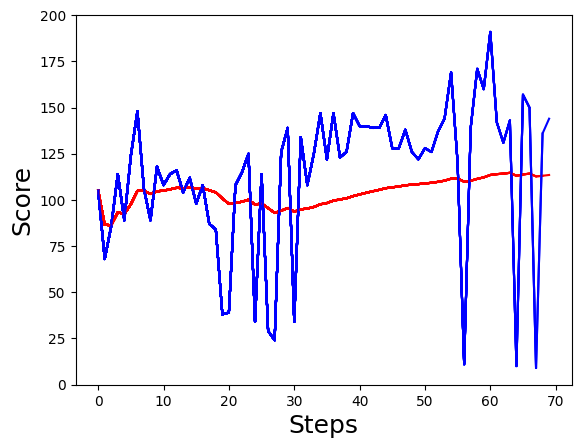

In [6]:
existing_model_path = "/content/drive/MyDrive/Bayesian_RL/cartpole-ddqn.h5"
EPISODES = 70
initial_epsilon = 0.3
decay_rate = 0.95

memory_df, rewards_per_episode, q_values = continuous_training(existing_model_path, EPISODES, initial_epsilon, decay_rate)

In [9]:
m_df = memory_df.copy()

In [10]:
m_df['state'] = m_df['state'].apply(lambda x: x[0])
m_df[['cart_position', 'cart_velocity', 'pole_angle', 'pole_angular_velocity']] = m_df['state'].apply(pd.Series)
m_df.drop(columns=['state'], inplace=True)
m_df['next_state'] = m_df['next_state'].apply(lambda x: x[0])
m_df[['new_cart_position', 'new_cart_velocity', 'new_pole_angle', 'new_pole_angular_velocity']] = m_df['next_state'].apply(pd.Series)
m_df.drop(columns=['next_state'], inplace=True)
order = ['episode','cart_position', 'cart_velocity', 'pole_angle', 'pole_angular_velocity', 'action','reward',
         'new_cart_position', 'new_cart_velocity', 'new_pole_angle', 'new_pole_angular_velocity', 'q_values']
m_df = m_df[order]
m_df

,episode,cart_position,cart_velocity,pole_angle,pole_angular_velocity,action,reward,new_cart_position,new_cart_velocity,new_pole_angle,new_pole_angular_velocity,q_values
0,0,-0.029321,-0.013128,-0.031011,0.004817,0,1.0,-0.029584,-0.207792,-0.030915,0.287557,"[9.239676, 9.115178]"
1,0,-0.029584,-0.207792,-0.030915,0.287557,0,1.0,-0.033740,-0.402459,-0.025164,0.570332,"[9.458932, 9.290105]"
2,0,-0.033740,-0.402459,-0.025164,0.570332,0,1.0,-0.041789,-0.597220,-0.013757,0.854982,"[9.663304, 9.446408]"
3,0,-0.041789,-0.597220,-0.013757,0.854982,0,1.0,-0.053733,-0.792151,0.003343,1.143308,"[9.97807, 9.729362]"
4,0,-0.053733,-0.792151,0.003343,1.143308,1,1.0,-0.069576,-0.597073,0.026209,0.851675,"[10.060754, 10.07632]"
...,...,...,...,...,...,...,...,...,...,...,...,...
7941,69,2.185362,1.588556,0.187633,0.585868,1,1.0,2.217133,1.780623,0.199350,0.357664,"[4.105403, 4.8583503]"
7942,69,2.217133,1.780623,0.199350,0.357664,1,1.0,2.252745,1.972435,0.206503,0.133865,"[3.9086094, 4.261493]"
7943,69,2.252745,1.972435,0.206503,0.133865,1,1.0,2.292194,2.164093,0.209181,-0.087232,"[4.3223004, 4.341317]"
7944,69,2.292194,2.164093,0.209181,-0.087232,0,1.0,2.335476,1.966682,0.207436,0.263481,"[4.6346793, 4.3247046]"


In [15]:
m_df.to_pickle('organized_training_memory4.pkl')

In [16]:
m_df.to_csv('organized_training_memory4.csv', index=False)

##### Testing

In [ ]:
test_agent = DQNAgent('CartPole-v1')
test_agent.test()

----------Double DQN--------
Model: "DDQN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_16 (Dense)            (None, 512)               2560      
                                                                 
 dense_17 (Dense)            (None, 256)               131328    
                                                                 
 dense_18 (Dense)            (None, 64)                16448     
                                                                 
 dense_19 (Dense)            (None, 2)                 130       
                                                                 
Total params: 150,466
Trainable params: 150,466
Non-trainable params: 0
_________________________________________________________________
Model: "DDQN"
_____________

/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


1/1 [==============================] - 0s 19ms/step
episode: 0/20, score: 13
1/1 [==============================] - 0s 19ms/step
episode: 1/20, score: 123
1/1 [==============================] - 0s 20ms/step
episode: 2/20, score: 125
1/1 [==============================] - 0s 79ms/step
episode: 3/20, score: 123
1/1 [==============================] - 0s 21ms/step
episode: 4/20, score: 124
1/1 [==============================] - 0s 20ms/step
episode: 5/20, score: 131
1/1 [==============================] - 0s 25ms/step
episode: 6/20, score: 123
1/1 [==============================] - 0s 27ms/step
episode: 7/20, score: 122
1/1 [==============================] - 0s 28ms/step


KeyboardInterrupt: ignored

##### Basic Model Training

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 31ms/step
episode: 139/150, score: 122, e: 0.01, average: 45.24, total_reward: 122.0
1/1 [==============================] - 0s 34ms/step
episode: 140/150, score: 214, e: 0.01, average: 46.43, total_reward: 214.0
1/1 [==============================] - 0s 17ms/step
episode: 141/150, score: 83, e: 0.01, average: 46.69, total_reward: 83.0
1/1 [==============================] - 0s 46ms/step
episode: 142/150, score: 107, e: 0.01, average: 47.11, total_reward: 107.0
1/1 [==============================] - 0s 22ms/step
episode: 143/150, score: 109, e: 0.01, average: 47.54, total_reward: 109.0
1/1 [==============================] - 0s 23ms/step
episode: 144/150, score: 117, e: 0.01, average: 48.02, total_reward: 117.0
1/1 [==============================] - 0s 18ms/step
episode: 145/150, score: 129, e: 0.01, average: 48.58, total_reward: 129.0
1/1 [==============================] - 0s 19ms/step
episode: 1

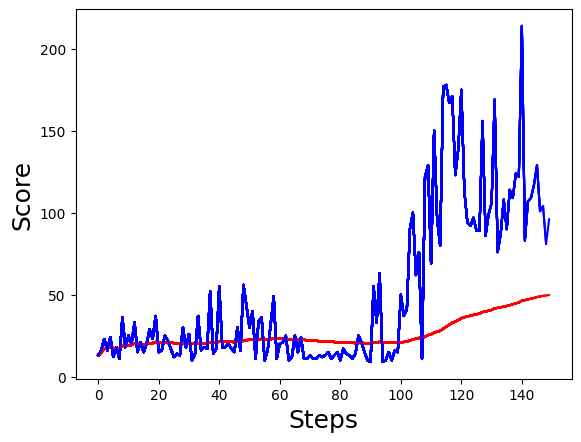

In [ ]:
env = 'CartPole-v1'
agent = DQNAgent(env)
agent.run()

In [ ]:
agent.save("cartpole-ddqn.h5")